## <font color = "#CC3D3D">Case #1: Binarization</font>

<hr>

### Step #1: Binarization of image
<hr>

- 영상의 이진화
    - 영상의 픽셀 값을 0 또는 255(1)로 만드는 연산
        - 배경 vs 객체
        - 관심 영역 vs 비관심 영역

- retval : 사용하지 않으려면 _, dst = cv2.threshold(parameter) 형태로 변수 할당

In [ ]:
import cv2
help(cv2.threshold)

In [ ]:
import cv2
import matplotlib.pyplot as plt

source = cv2.imread("images/cells.png", cv2.IMREAD_GRAYSCALE)

T1, destination1 = cv2.threshold(source, 80, 255, cv2.THRESH_BINARY)
T2, destination2 = cv2.threshold(source, 210, 255, cv2.THRESH_BINARY)

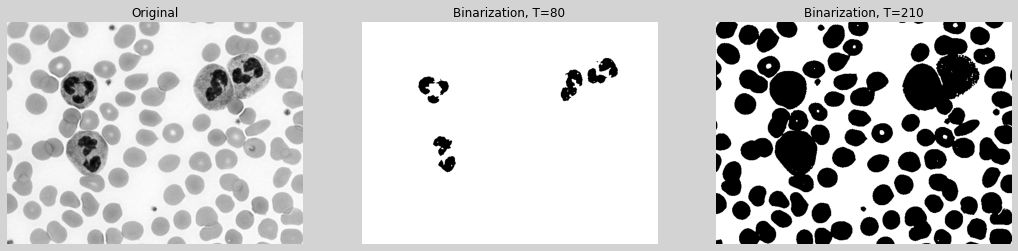

-1

In [90]:
# pyplot으로 출력
plt.figure(figsize=(18, 6), facecolor="lightgray")

plt.subplot(131, title="Original").axis("off")
plt.imshow(source, "gray")

plt.subplot(132, title=f"Binarization, T={int(T1)}").axis("off")
plt.imshow(destination1, "gray")

plt.subplot(133, title=f"Binarization, T={int(T2)}").axis("off")
plt.imshow(destination2, "gray")

plt.show()

In [ ]:
# 트랙바 사용
def on_threshold(value):
    _, result = cv2.threshold(
        src=source,
        thresh=value,
        maxval=255,
        type=cv2.THRESH_BINARY
        )
    cv2.imshow("Binarization", result)

In [ ]:
# OpenCV 가상 윈도우로 출력
cv2.imshow("Original", source)
cv2.namedWindow("Binarization")
cv2.createTrackbar("Threshold", "Binarization", 210, 255, on_threshold)
on_threshold(210)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

## <font color = "#CC3D3D">Case #2: Automatic Binarization</font>

<hr>

### Step #1: How to automatic binarization
<hr>



<hr>

### Step #2: implementation example
<hr>

In [12]:
import cv2
import matplotlib.pyplot as plt

source = cv2.imread("images/rice.png", cv2.IMREAD_GRAYSCALE)

# or 연산자를 통해 cv2.THRESH_BINARY 플래그를 지정하지 않아도 있다고 가정한다.
# 한편, inverse된 이진화 영상을 얻고 싶으면 cv2.THRESH_BINARY_INV 플래그를 or 연산자로 묶어서 지정하면 된다.
value, destination = cv2.threshold(source, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
print("otsu's threshold:", value)

otsu's threshold: 131.0


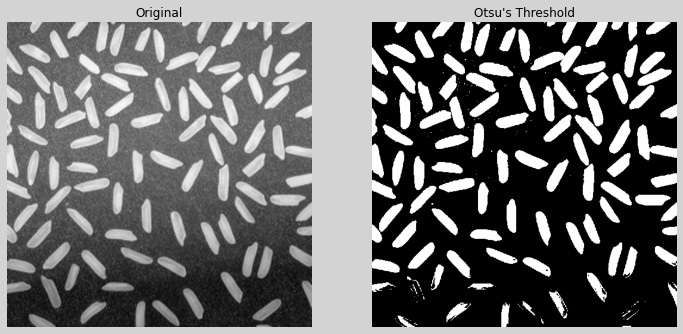

In [13]:
# pyplot으로 출력
plt.figure(figsize=(12, 6), facecolor="lightgray")

plt.subplot(121, title="Original").axis("off")
plt.imshow(source, "gray")

plt.subplot(122, title="Otsu's Threshold").axis("off")
plt.imshow(destination, "gray")

plt.show()

#### NOTE: 조명이 뷸균일하여 영상의 하단 부분은 이진화가 정확하게 되지 않는 모습을 볼 수 있다.

In [ ]:
# OpenCV 가상 윈도우로 출력
cv2.imshow("Original", source)
cv2.imshow("Otsu's Threshold", destination)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

## <font color = "#CC3D3D">Case #3: Local Binarization</font>

전체 영상을 균일한 크기로 n등분. 각각의 구역마다 따로 이진화를 구현하고 이어 붙인다.
윈도우 형태 
    - 유니폼: 부분영상 전체를 같은 가중치로 계산
    - 가우시안: 2D 가우시안 그래프 형태로 중앙 부근은 높은 가중치, 중앙에서 멀어질수록 낮은 가중치


<hr>

### Step #2: Manually implementation example
<hr>

In [107]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

source = cv2.imread("images/rice.png", cv2.IMREAD_GRAYSCALE)


# 입력 영상을 가로 4 세로 4 총 16 등분하여 각각 이진화
def local_binarization(image, value):
    result = np.zeros(image.shape, np.uint8)
    
    block_width = image.shape[1] // value
    block_height = image.shape[0] // value
    
    for y in range(value):
        for x in range(value):
            image_ = image[
                y * block_height:(y+1) * block_height,  # rows
                x * block_width:(x+1) * block_width     # cols
                ]
            result_ = result[
                y * block_height:(y+1) * block_height,  # rows
                x * block_width:(x+1) * block_width     # cols
                ]
            cv2.threshold(image_, 0, 255, cv2.THRESH_OTSU, result_)

    print("Local Binarization is done!")
    return result


destination = local_binarization(source, 4)

Local Binarization is done!


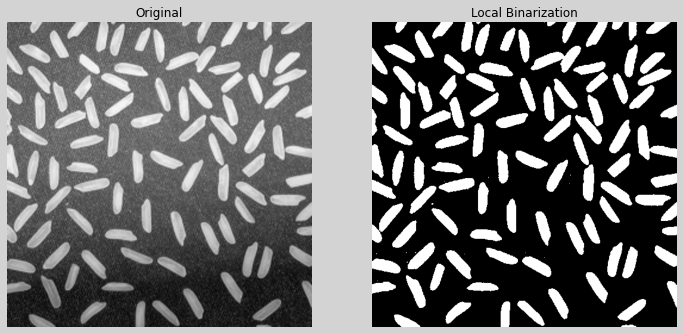

In [102]:
# pyplot으로 출력
plt.figure(figsize=(12, 6), facecolor="lightgray")

plt.subplot(121, title="Original").axis("off")
plt.imshow(source, "gray")

plt.subplot(122, title="Local Binarization").axis("off")
plt.imshow(destination, "gray")

plt.show()

In [103]:
# 트랙바 사용하기
def on_trackbar(value):
    if value == 0:
        value = 1
    elif value > 1 and value % 2:
        value -= 1
    
    # 입력 영상을 가로, 세로 value 만큼 총 value x value 등분하여 각각 이진화
    destination = local_binarization(source, value)
    
    cv2.imshow("Local Binarization", destination)

In [104]:
# OpenCV 가상 윈도우로 출력
cv2.imshow("Original", source)
cv2.namedWindow("Local Binarization")
cv2.createTrackbar("window ratio", "Local Binarization", 4, 20, on_trackbar)
on_trackbar(4)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

<hr>

### Step #2-1: Function implementation example
<hr>

In [ ]:
import cv2
help(cv2.adaptiveThreshold)

In [ ]:
import cv2
import numpy as np

source = cv2.imread("images/sudoku.jpg", cv2.IMREAD_GRAYSCALE)

destination = cv2.adaptiveThreshold(
        src=source,
        maxValue=255,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv2.THRESH_BINARY,
        blockSize=91,
        C=5
        )

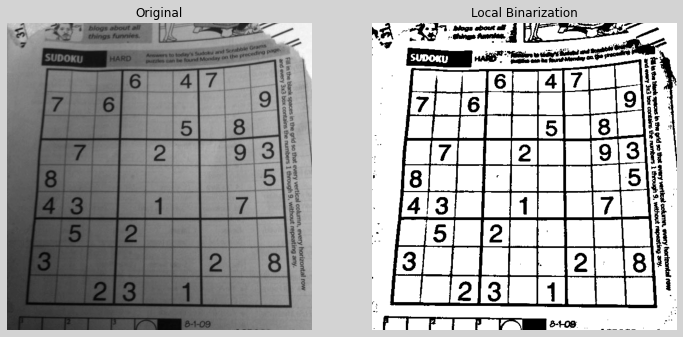

In [98]:
# pyplot으로 출력
plt.figure(figsize=(12, 6), facecolor="lightgray")

plt.subplot(121, title="Original").axis("off")
plt.imshow(source, "gray")

plt.subplot(122, title="Local Binarization").axis("off")
plt.imshow(destination, "gray")

plt.show()

In [ ]:
# 트랙바 사용하기
def on_trackbar(value):
    block_size = 3 if value < 3 else value if value % 2 else value - 1
    
    destination = cv2.adaptiveThreshold(
        source, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, 5
        )
    
    cv2.imshow("Local Binarization", destination)

In [79]:
# OpenCV 가상 윈도우로 출력
cv2.imshow("Original", source)
cv2.namedWindow("Local Binarization")
cv2.createTrackbar("block size", "Local Binarization", 5, 100, on_trackbar)
on_trackbar(5)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

## <font color = "#CC3D3D">Case #4: Morphology</font>

<hr>
### Step #1: Erosion & Dilation
<hr>
3x3 정방형 행렬이 가장 많이 쓰인다.

In [ ]:
import cv2
help(cv2.getStructuringElement)

In [ ]:
import cv2
help(cv2.erode)

In [ ]:
import cv2
help(cv2.dilate)

In [112]:
import cv2
import matplotlib.pyplot as plt

source = cv2.imread("images/circuit1.bmp", cv2.IMREAD_GRAYSCALE)

structur = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 3))
destination1 = cv2.erode(source, structur)

structur = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 7))
destination2 = cv2.dilate(source, structur)

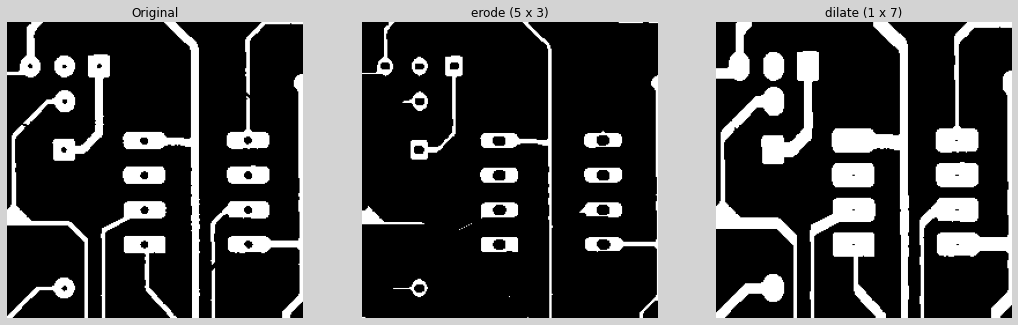

In [114]:
# pyplot으로 출력
plt.figure(figsize=(18, 6), facecolor="lightgray")

plt.subplot(131, title="Original").axis("off")
plt.imshow(source, "gray")

plt.subplot(132, title="erode (5 x 3)").axis("off")
plt.imshow(destination1, "gray")

plt.subplot(133, title="dilate (1 x 7)").axis("off")
plt.imshow(destination2, "gray")

plt.show()

In [ ]:
# OpenCV 가상 윈도우로 출력
cv2.imshow("Original", source)
cv2.imshow("erode (5 x 3)", destination1)
cv2.imshow("dilate (1 x 7)", destination2)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

<hr>

### Step #2: Opening & Closing
<hr>

In [ ]:
import cv2
help(cv2.morphologyEx)

In [11]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

source = cv2.imread("images/rice.png", cv2.IMREAD_GRAYSCALE)


def local_binarization(image, value):
    result = np.zeros(image.shape, np.uint8)
    
    block_width = image.shape[1] // value
    block_height = image.shape[0] // value
    
    for y in range(value):
        for x in range(value):
            image_ = image[
                y * block_height:(y+1) * block_height,  # rows
                x * block_width:(x+1) * block_width     # cols
                ]
            result_ = result[
                y * block_height:(y+1) * block_height,  # rows
                x * block_width:(x+1) * block_width     # cols
                ]
            cv2.threshold(image_, 0, 255, cv2.THRESH_OTSU, result_)

    print("Local Binarization is done!")
    return result


destination = local_binarization(source, 4)
count1, _ = cv2.connectedComponents(destination)
print("count1:", count1)

opening = cv2.morphologyEx(destination, cv2.MORPH_OPEN, None)
count2, _ = cv2.connectedComponents(opening)
print("count2:", count2)



Local Binarization is done!
count1: 113
count2: 99


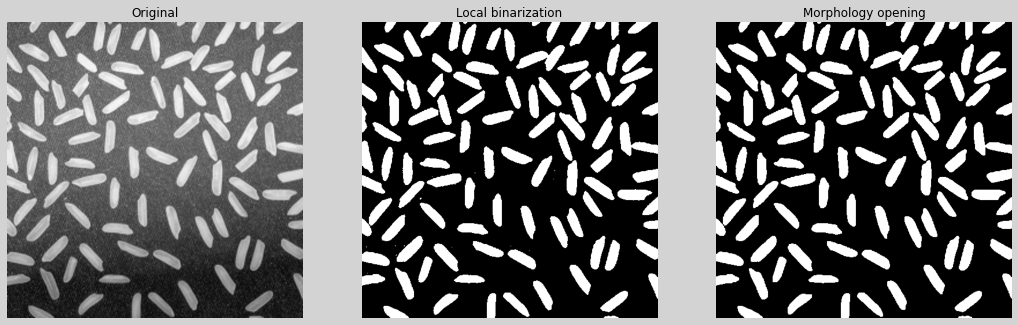

In [10]:
# pyplot으로 출력
plt.figure(figsize=(18, 6), facecolor="lightgray")

plt.subplot(131, title="Original").axis("off")
plt.imshow(source, "gray")

plt.subplot(132, title="Local binarization").axis("off")
plt.imshow(destination, "gray")

plt.subplot(133, title="Morphology opening").axis("off")
plt.imshow(opening, "gray")

plt.show()

In [8]:
# OpenCV 가상 윈도우로 출력
cv2.imshow("Original", source)
cv2.imshow("Local binarization", destination)
cv2.imshow("Morphology opening", opening)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

## <font color = "#CC3D3D">Case #5: Labeling</font>

속도가 레이블링이 외곽선 검출보다 빠르다. 연산이 더 효율적

In [166]:
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np

source = cv2.imread("images/keyboard.bmp", cv2.IMREAD_GRAYSCALE)

_, binarization = cv2.threshold(source, 0, 255, cv2.THRESH_OTSU)
binarization = cv2.morphologyEx(binarization, cv2.MORPH_OPEN, None)  # 노이즈 제거

count, labels, stats, centroids = cv2.connectedComponentsWithStats(binarization)

destination = cv2.cvtColor(source, cv2.COLOR_GRAY2BGR)

# print(len(np.unique(labels[labels > 0])))  # 객체 수: 18개
for i in range(1, 19):
    num1 = random.randint(0, 255)
    num2 = random.randint(0, 255)
    num3 = random.randint(0, 255)
    destination[labels == i] = ((i*10)+num1, (i*10)-num2, (i*10)+num3)

for i in range(1, count):
    x, y, w, h, _ = stats[i]
    
    center_x = round(centroids[i][0])
    center_y = round(centroids[i][1])
    
    cv2.rectangle(destination, (x, y, w, h), (0, 255, 0), 1, cv2.LINE_AA)
    
    destination[center_y-1:center_y+2, center_x-1:center_x+2] = (0, 255, 0)  # 중심점 표시

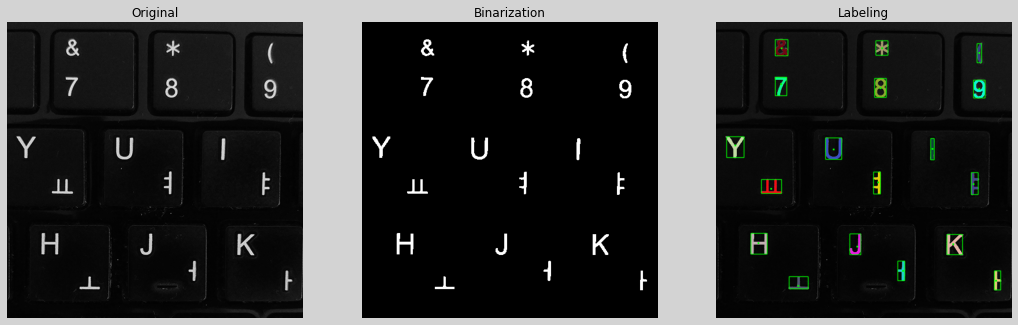

In [167]:
# pyplot으로 출력
plt.figure(figsize=(18, 6), facecolor="lightgray")

plt.subplot(131, title="Original").axis("off")
plt.imshow(source, "gray")

plt.subplot(132, title="Binarization").axis("off")
plt.imshow(binarization, "gray")

plt.subplot(133, title="Labeling").axis("off")
plt.imshow(destination[:, :, ::-1])

plt.show()

In [169]:
# OpenCV 가상 윈도우로 출력
cv2.imshow("Original", source)
cv2.imshow("Binarization", binarization)
cv2.imshow("Labeling", destination)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

## <font color = "#CC3D3D">Case #6: Contour Tracing</font>